In [28]:
import sys
sys.path.append("./DiffMatte")

checkpoint_path = "checkpoints/DiffMatte_ViTS_Com_1024.pth"
config_file = "DiffMatte/configs/ViTS_1024.py"
image_path = "DiffMatte/demo/retriever_rgb.png"
trimap_path = "DiffMatte/demo/retriever_trimap.png"

In [29]:
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from re import findall
from detectron2.config import LazyConfig, instantiate
from detectron2.checkpoint import DetectionCheckpointer


def get_data(image_path, trimap_path):
    """
    画像と trimap を読み込み、テンソル化する。
    """
    # 画像をRGBに変換して読み込み
    image = Image.open(image_path).convert("RGB")
    image = F.to_tensor(image).unsqueeze(0)

    # trimap をグレースケールで読み込み
    trimap = Image.open(trimap_path).convert("L")
    trimap = F.to_tensor(trimap).unsqueeze(0)

    # trimap の値を 0, 0.5, 1 の3値にする
    trimap[trimap > 0.9] = 1.0
    trimap[(trimap >= 0.1) & (trimap <= 0.9)] = 0.5
    trimap[trimap < 0.1] = 0.0

    return {"image": image, "trimap": trimap}


def init_model(config_file, checkpoint, device, sample_strategy):
    cfg = LazyConfig.load(config_file)

    if sample_strategy is not None:
        cfg.difmatte.args["use_ddim"] = True if "ddim" in sample_strategy else False
        # sample_strategy 内の数字を抽出して diffusion ステップ数とする
        cfg.diffusion.steps = int(findall(r"\d+", sample_strategy)[0])

    model = instantiate(cfg.model)
    diffusion = instantiate(cfg.diffusion)
    cfg.difmatte.model = model
    cfg.difmatte.diffusion = diffusion
    difmatte = instantiate(cfg.difmatte)

    difmatte.to(device)
    difmatte.eval()
    DetectionCheckpointer(difmatte).load(checkpoint)

    return difmatte


def infer_one_image(model, data):
    output = model(data)
    return output


def convert_bgr2rgb(image_bgr):
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


def pil2cv(image_pil, convert_channel=True):
    image_np = np.array(image_pil, dtype=np.uint8)
    if convert_channel:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return image_np


def show_image_from_ndarray(image_array, figsize=None, bgr2rgb=True):
    if figsize is not None:
        plt.figure(figsize=figsize)

    if (len(image_array.shape) < 3) or (image_array.shape[-1] == 1):
        plt.imshow(image_array)
        plt.axis("off")
    else:
        if bgr2rgb:
            plt.imshow(convert_bgr2rgb(image_array))
        else:
            plt.imshow(image_array)
        plt.axis("off")

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sample_strategy = "ddim10"

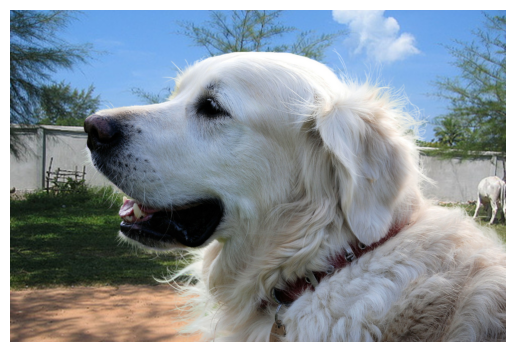

In [31]:
orig_img = cv2.imread(image_path)
if orig_img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

show_image_from_ndarray(orig_img)

In [32]:
print("Initializing model... Please wait.")
data = get_data(image_path, trimap_path)
model = init_model(config_file, checkpoint_path, device, sample_strategy)
print("Model initialized. Running inference...")
output = infer_one_image(model, data)
print("Inference finished.")

Initializing model... Please wait.
Model initialized. Running inference...


ddim sampling loop time step: 100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.76it/s]


Inference finished.


In [33]:
image_bgr = data["image"].squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)[..., ::-1]
trimap = data["trimap"].squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
x_t = data["x_t"].squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

[0.  0.5 1. ]


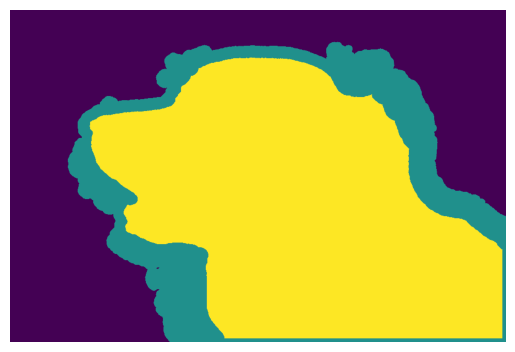

In [34]:
print(np.unique(trimap))
show_image_from_ndarray(trimap)

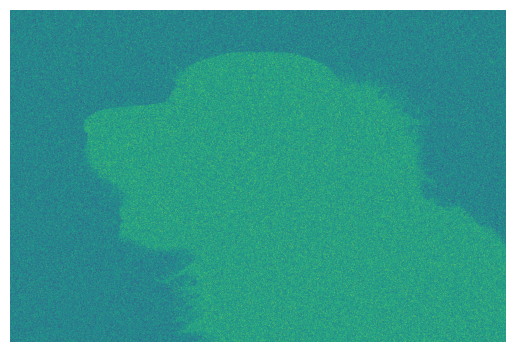

In [35]:
show_image_from_ndarray(x_t)

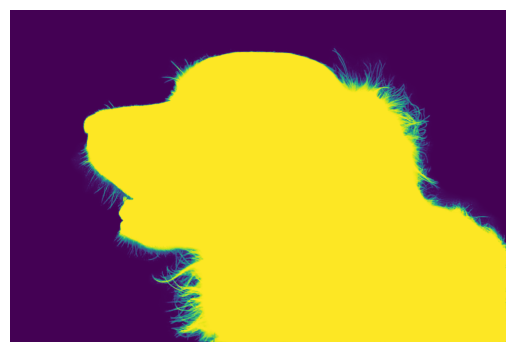

In [36]:
show_image_from_ndarray(output)